In [1]:
import gym
from stable_baselines3 import A2C, PPO
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce
from itertools import count
from gymenv.PlaytimeEnv import PlaytimeEnv
from objects.Maneuver import Mission_Maneuver
from objects.AllManeuvers import LIST_MAN
from objects.Plane import Plane
from function.tools import *
# https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
# https://stable-baselines3.readthedocs.io/en/master/modules/base.html
LEARN = 0

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


The list of parameters that follow in the next cell represent the gameplan parameters.
Among them, there are :
- The **plane**, with a custom object, containing informations about the maximum and minimum speed, fuel consumption, fuel tank, max flight time...  
    - TODO : We need to complete those information in the futur, by adding the payload, having a custom-made more accurate fuel consumption function...
    
- The **goal distance**, representing the distance between the plane and the mission location.  
    - TODO : Add a time constraint to make a decision about how to travel this distance at the beginning of the mission (speed and altitude).  
    - TODO : Add a zone constraint with SAM or ennemies that will change the trajectory (instead of a direct line).  

- The **RtB distance** or **Return to base distance** : this is the distance between the mission location and the return point, an allied base, supply point or safe location.  
    - TODO : Use the time constraint about the synchroTime (following in the next parameters) to make a decision about how to travel this distance considering what has been done during the mission.  
    - TODO : Like the goal distance, add a zone constraint with SAM or ennemies that will change the trajectory.

- The amount of **fuel available** at the beginning of the mission. This amount of fuel can't be higher than what can the plane hold.
    - No Todos 
    
- The **meteo** during this mission. Depending of the weather, it has an impact on the altitude or the radius of action.  
    - TODO : We can add a changing weather in the environment to add a certain adaptation and randomness.

- The **type of the mission** : for now there are only two (or three with the **SWEEP** but NYI with the **CAS** and **SCAR** missions. The first one (*Close Air Support*) consists of helping and supporting allies on the ground with recon or attack maneuvers. The second one, *Strike Coordination And Recce*, is an intimidation and research on zone mission. Depending on the type of mission, some maneuvers are recommended / needed in order to complete the mission.

    - TODO : Implement new maneuvers or change parameters according to the mission : it would be good to have a real difference between the two actual types of mission.
    - TODO : Implement **SWEEP**, with new maneuvers and type of decision needed

- The **power relations** between the pilote / allies and their ennemies. It's important to know if the pilote has the advantage during the mission : if he has the advantage, then he is safer and can reduce his average speed in order to consume less. On the contrary, if he is at disadvantage, he will have to counter the balance by speeding up.

  - TODO : add a changing power relations, reducing as time passes (we assume the ennemies have been eliminated)
  - TODO : add more details, calculate it with the number of allies, opponents, weaponry, machinery, type of support...
  - TODO : add local power relation, changing according to the zone in which the maneuver will be done.

- The **minimum time** spent on the zone in order to accomplish the mission. This value is required by the support when they ask the pilote if the mission can be done. If it can be reached, it will either go to the synchronization time or consume all the fuel remaining. If not, then it will consume all the fuel to try and reach this minimum time.
    - No Todos

- The **synchronization time** is the time at which the pilote need to be at the supply point in order to get refueled at the right moment. It is the maximum time available on the mission, it is needed to reach the closest time. If there are no synchronization time, it will consume all the fuel remaining.
  - No Todos 


- TODO : Try to add new agents for prediction, see MCTS algorithm.


- TODO : Add objective points for the mission : each objective needs a certain maneuver and has a few local parameters like the type of action needed, the zone of action (for maneuvers like **Spiral** or **ZigZag**), the power balance, etc. Plus, it can help in the choice of the number and the different maneuvers, instead of having an unknown amount of maneuvers.


- TODO : Add calculation for trajectory and change of altitude, it may not be interesting to go up compared to the saved fuel... Add full flight dynamic.


- TODO : Add a path solver between the objective points. After a maneuver, we need the pilote to move to the next objective in the best way possible. This way, we can make the environment in 2 dimensions, considering the altitude and the distance. Moreover, we need to consider the potentiel threats between the objective points.


- TODO : Adapt gameplans parameters if the mission is a **SWEEP** : the global philosophy of this mission is completely different from the two others, maybe a whole new environment is needed.


- TODO : Add field data like topography. It can help in the path solving for the altitude among others.

In [2]:
ULM = Plane()
# This parameters list can be changed but careful because the PlaytimeEnv accept
# only this. Don't forget to change in the environment too.
# TODO : add Min maneuvers (parameters from the pilot)
param_list = {
    'Plane': [ULM],
    'GoalDistance': [0, 10, 15, 20, 30],
    'RtBDistance': [0, 10, 15, 20, 30],
    'FuelAvailable': [15, 20, 30, 35, 40, 60, 80, 100, 120],
    # Start with just 3 states : sunny, cloudy or misty.
    'Meteo': ["Sunny", "Cloudy", "Misty"],
    'MissionType': [Mission_Maneuver.SCAR, Mission_Maneuver.CAS],  # 
    # Add ennemies number afterwards, weaponry
    'Strength': ['Weak', 'Equal', 'Strong'],
    'TimeMin': [0, 1800, 3600],
    'SynchroTime': [0, 1800, 3600],
}
combinations = get_all_combinations(param_list)
combinations = list(filter(lambda x: x['TimeMin'] < x['SynchroTime']
                    or x['SynchroTime'] == 0, combinations))
print(len(combinations))
env = PlaytimeEnv(combinations)
print(env.observation_space.sample())

Cet avion peut voler pendant  40000  s, soit  666  min, soit 2000  km à une vitesse moyenne de  180  km/h et sa vitesse max sera de  220  km/h
24300
Dict(FuelAvailable: Discrete(121), GoalDistance: Discrete(31), Meteo: Discrete(3), MissionType: Discrete(2), Plane: Discrete(1), RtBDistance: Discrete(31), Strength: Discrete(3), SynchroTime: Discrete(3601), TimeMin: Discrete(3601), fuel: Discrete(121), time: Discrete(40001))
MultiDiscrete([  4  16 162  31   4  15  15   4])
OrderedDict([('FuelAvailable', 48), ('GoalDistance', 21), ('Meteo', 1), ('MissionType', 1), ('Plane', 0), ('RtBDistance', 21), ('Strength', 1), ('SynchroTime', 1046), ('TimeMin', 1839), ('fuel', 13), ('time', 24198)])


In [3]:
# Parallel environments
timesteps = [10000, 15000, 20000, 25000, 30000]
if LEARN:
    for timestep in timesteps:
        env = PlaytimeEnv(combinations)

        model = A2C("MultiInputPolicy", env, verbose=1)
        model.learn(total_timesteps=timestep)
        model.save("a2c_playtime" + str(timestep))

        del model # remove to demonstrate saving and loading

In [16]:
all_rewards_timesteps_a2c = []
timesteps = [25000]

for timestep in timesteps:
    model = A2C.load("a2c_playtime"+str(timestep))
    nb_episode = 1
    nb_occ = 0
    obs = env.reset(verbose=0)
    print(obs)
    all_rewards = []
    while nb_occ != nb_episode:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        print(action)
        if dones == True:
            # print("Reward : ", rewards)
            all_rewards.append(rewards)
            print([(m.name.name, m.meanspeed, m.travelled_time(), m.total_fuel_consumption()) for m in env.maneuver_list])
            obs = env.reset(verbose=1)
            nb_occ += 1
    all_rewards_timesteps_a2c.append(all_rewards)

{'fuel': 0, 'time': 0, 'Plane': 0, 'GoalDistance': 30, 'RtBDistance': 10, 'FuelAvailable': 100, 'Meteo': 2, 'MissionType': 0, 'Strength': 1, 'TimeMin': 0, 'SynchroTime': 0}
[ 2 12  9  6  3  4  8  0]
[ 3 12  9 20  3  1 11  0]
[ 3 12  9  9  3  4  8  0]
[ 2  6  9  5  3  3 11  0]
[ 3 12  9  5  3  4 11  0]
[ 2 12  9  6  3  4 11  0]
[ 3 12  9 20  3  3 11  0]
[ 2 19  9  5  3  3 11  0]
[ 2 12  9  5  3  3  1  0]
[ 2 12  9  5  3  4 11  0]
[ 3 12  9  5  3  4 11  0]
[ 2 12 98  5  3  4 11  0]
[ 3 12  9 20  3  4  8  0]
[ 2 12  9  5  3  4 11  0]
[('Zigzag', 200, 1573.56, 9.73), ('ShowOfForce', 200, 464.5, 2.73), ('ShowOfForce', 200, 464.5, 2.73), ('Zigzag', 170, 2208.07, 11.51), ('ShowOfForce', 200, 464.5, 2.73), ('Zigzag', 200, 1966.86, 12.16), ('ShowOfForce', 200, 464.5, 2.73), ('Zigzag', 235, 1597.33, 11.7), ('Zigzag', 200, 1126.08, 6.96), ('Zigzag', 200, 1966.86, 12.16), ('ShowOfForce', 200, 464.5, 2.73), ('Zigzag', 200, 1966.86, 10.85), ('ShowOfForce', 200, 464.5, 2.73), ('Zigzag', 200, 1966.86,

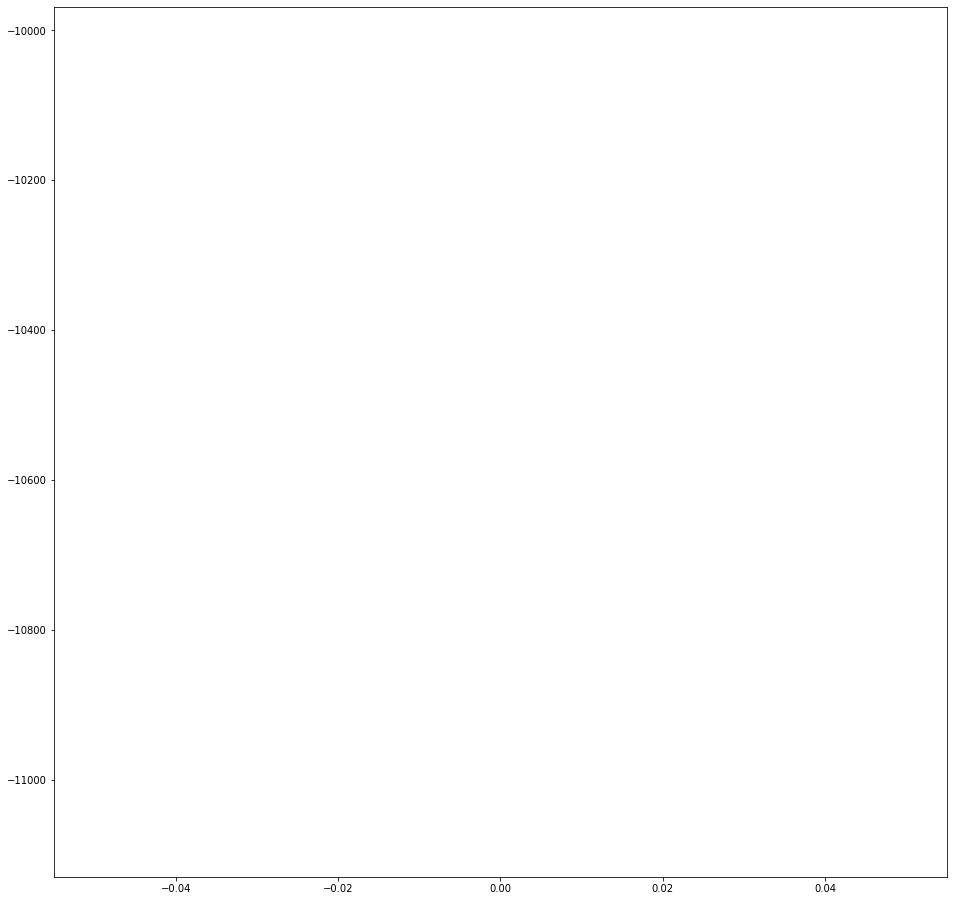

In [5]:
fig = plt.figure(figsize=(16, 16))
for i, all_rewards in enumerate(all_rewards_timesteps_a2c):
    ax1 = fig.add_subplot(len(all_rewards_timesteps_a2c), len(all_rewards_timesteps_a2c),i+1) 
    ax1.plot(all_rewards)
plt.show()

In [6]:
# Parallel environments
timesteps = [10000, 15000, 20000, 25000, 30000]

LEARN = 0
if LEARN:
    for timestep in timesteps:
        env = PlaytimeEnv(combinations)

        model = PPO("MultiInputPolicy", env, verbose=1)
        model.learn(total_timesteps=timestep)
        model.save("ppo_playtime" + str(timestep))

        del model # remove to demonstrate saving and loading

In [7]:
all_rewards_timesteps_ppo = []
for timestep in timesteps:
    model = PPO.load("ppo_playtime"+str(timestep))
    nb_episode = 1000
    nb_occ = 0
    obs = env.reset(verbose=0)
    # print(obs)
    all_rewards = []
    while nb_occ != nb_episode:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        if dones == True:
            # print("Reward : ", rewards)
            all_rewards.append(rewards)
            # print([(m.name.name, m.meanspeed, m.travelled_time(), m.total_fuel_consumption()) for m in env.maneuver_list])
            obs = env.reset(verbose=0)
            nb_occ += 1
    all_rewards_timesteps_ppo.append(all_rewards)


TypeError: unsupported operand type(s) for +: 'int' and 'method'

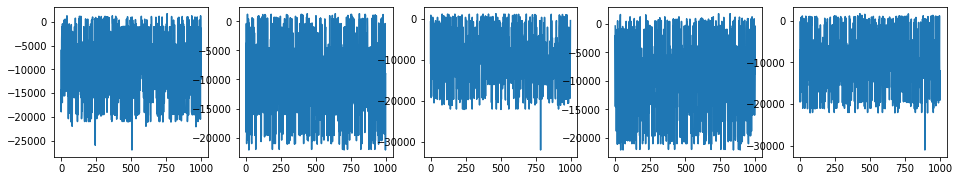

In [ ]:
fig = plt.figure(figsize=(16, 16))
for i, all_rewards in enumerate(all_rewards_timesteps_ppo):
    ax1 = fig.add_subplot(len(all_rewards_timesteps_ppo), len(all_rewards_timesteps_ppo),i+1) 
    ax1.plot(all_rewards)
plt.show()